## Level 1 Requirement Flowdown

### L1-4 Global Fluxes (Global Mode)

> Carbon-I shall obtain column averaged mixing ratios with a standard error of ≤12 ppb CH4, ≤2.5 ppm CO2, and ≤10 ppb for CO once averaged to a 12 km × 12 km grid resolution for over 50% of such grid each month¹.  



### L1-5 Regional Fluxes (Target Mode)

> For representative regions² (90 km × 90 km) Carbon-I shall obtain column averaged mixing ratios with a standard error ≤8 ppm CH4, ≤1.6 ppm CO2, and ≤10 ppb CO once averaged to a 1 km × 1 km grid for our reference scenario4 with a revisit capability ≤7 days. 


¹: Averaged over 12 months.

²: Representative regions are those that best exemplify major emission sectors—wetlands, agriculture, and waste—where emission uncertainty is high and process-based understanding remains limited.

---

Let's codify these numbers

In [128]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI, vSmartMOM, Printf
using CairoMakie, DelimitedFiles, Statistics, Interpolations
include(joinpath("../../src/Plots", "CI_colorsNew.jl"));

  Activating project at `~/code/gitHub/CarbonI`


In [115]:
# Define numbers from L1 R

In [125]:
# Define numbers from L1 Requirements

# Global Mode (L1-4)
global_mode_ch4_error = 12.0            # in ppb
global_mode_co2_error = 2.5             # in ppm
global_mode_co_error = 10.0             # in ppb
global_mode_grid_resolution = [12e3, 12e3]  # in m
global_mode_coverage = 50.0             # in percentage
global_mode_gsd_req  = [400.0, 400.0]           # in m
global_mode_gsd_cbe  = [305.0, 345.0]   # in m

# Regional Mode (L1-5)
regional_mode_ch4_error = 8.0  # in ppb
regional_mode_co2_error = 1.6  # in ppm
regional_mode_co_error = 10.0  # in ppb
regional_mode_grid_resolution = (1, 1)  # in km
regional_mode_revisit_days = 7  # in days
regional_mode_region_size = (90, 90)  # in km

# Reference Background VMRs
background_vmr_ch4 = 1950.0  # in ppb
background_vmr_co2 = 410.0   # in ppm
background_vmr_n2o = 320.0   # in ppb

320.0

In [117]:
# Read cloud median statistics in 10S-10N from Yinon
cs = readdlm("../../data/CloudStatsCentralAmazonia.dat");
cf_interp = LinearInterpolation(cs[:,1], cs[:,2], extrapolation_bc=Line());
gsds = 30:10:1000;

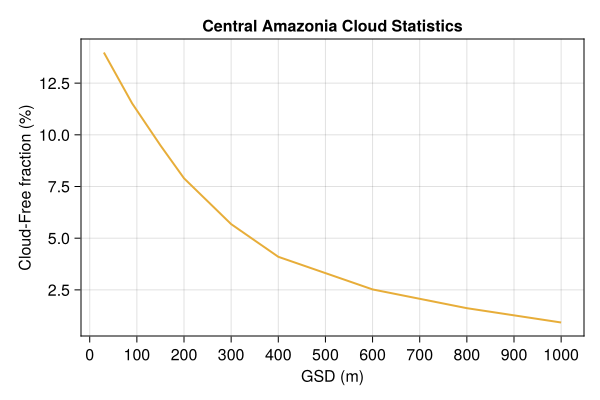

In [118]:
f = Figure(resolution=(600,400))
ax = Axis(f[1,1], xlabel="GSD (m)", ylabel="Cloud-Free fraction (%)", xticks = 0:100:1000, title="Central Amazonia Cloud Statistics")
lines!(ax, gsds, 100cf_interp.(gsds), color=CarbonI_colors[1], linewidth=2)
f

Now we can compute the potential number of footprints in the global grid, i.e.
$$
N_{max} = \frac{GSD_x \times GSD_y}{Grid_x \times Grid_y}
$$:

In [119]:
# Maximum number of global ground pixels in the 12km box
# Req.
N_max_global_req = prod(global_mode_grid_resolution)/prod(global_mode_gsd_req);
# At CBE
N_max_global_cbe = prod(global_mode_grid_resolution)/prod(global_mode_gsd_cbe);

And apply the conservative cloud statistics in the central Amazon (neglecting that we can tolerate higher sub-pixel clouds)

In [124]:
# Number of cloud-free global ground pixels in the 12km box
# Req.
N_eff_global_req = N_max_global_req * cf_interp(sqrt(prod(global_mode_gsd_req)));
# At CBE
N_eff_global_cbe = N_max_global_cbe * cf_interp(sqrt(prod(global_mode_gsd_cbe)));

We can now derive the requirement for $\sigma_{s}^{rel}$, as:
$$
\sigma_s^{rel} < \underbrace{\sigma_{agg}^{rel}}_{Required} \times \sqrt{N_{eff}}  
$$

In [143]:
sigma_rel_agg_global_req      =  min(global_mode_ch4_error/background_vmr_ch4 ,  global_mode_co2_error/background_vmr_co2)  # This should effectively be the same relative error for CO2 and CH4
sigma_rel_SingleSounding_req  =  sigma_rel_agg_global_req * sqrt(N_eff_global_req)  
sigma_rel_SingleSounding_cbe  =  sigma_rel_agg_global_req * sqrt(N_eff_global_cbe)
@printf("Required Single Measurement Precision for N₂O in percent for req. GSD : %.3g\n", 100*sigma_rel_SingleSounding_req)
@printf("Required Single Measurement Precision for N₂O in percent for CBE specs: %.3g\n", 100*sigma_rel_SingleSounding_cbe)

Required Single Measurement Precision for N₂O in percent for req. GSD : 3.7
Required Single Measurement Precision for N₂O in percent for CBE specs: 5.19


Just to show that the CH4 or CO2 precisions hardly matter for the relative errors:
$$
\sigma_{\mathrm{rel}}(R)
\;=\;\sqrt{\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{CH_4,CO_2}}\bigr)
+\;\sigma_{\mathrm{rel}}^2\!\bigl(\Omega_{\mathrm{N_2O}}\bigr)\,},
$$

In [ ]:
σ_n2o = 3.5 # Error in %
σ_ghg = 0.5 # Error in % (CO2 and CH4, even smaller than that)
σ_rel = sqrt(σ_n2o^2 + σ_ghg^2)
@printf("Error Enhancement factor if also considering GHG noise: %.3g\n", σ_rel / σ_n2o)

Error Enhancement factor if also considering GHG noise: 1.01


Now we have to show what instrument specs we require to get to that precision. 
--> We could bypass SNR and just use our tropical reference scene (with spectrally varying albedo) and compute sigma as function of total system efficiency (i.e. optical throughput and Qe)